# Ensemble - Voting 방식
- 서로 다른 종류의 알고리즘들을 결합하여 다수결 방식으로 최종 결과를 출력한다.

## Voting의 유형
1. **hard voting**
    - 다수의 추정기가 결정한 예측값들 중 많은 것을 선택하는 방식
    
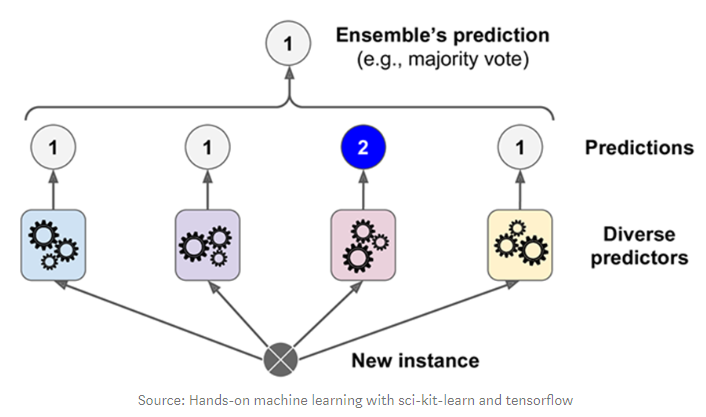  

2. **soft voting**
    - 다수의 추정기에서 각 레이블별 예측한 확률들의 평균을 내서 높은 레이블값을 결과값으로 선택하는 방식

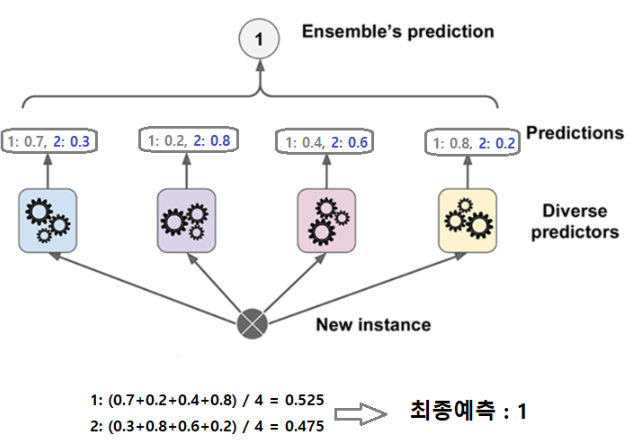

- 일반적으로 soft voting이 성능이 더 좋다.    
- Voting은 성향이 다르면서 비슷한 성능을 가진 모델들을 묶었을때 가장 좋은 성능을 낸다.

## VotingClassifier 클래스 이용
- 매개변수
    - estimators : 앙상블할 모델들 설정.  ("추정기이름", 추정기) 의 튜플을 리스트로 묶어서 전달
    - voting: voting 방식. hard(기본값), soft  지정

## 위스콘신 유방암 데이터셋으로 실습

##### import

In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from sklearn.metrics import accuracy_score

##### 데이터셋 로딩 및 train/test set 나누기

In [2]:
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, 
                                                    random_state=0)

##### Data전처리
- SVM, KNN은 Feature Scaling 전처리 데이터를 사용
- Random Forest는 Decision Tree기반이므로 Feature Scaling이 필요없다.

In [3]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

##### 모델들 생성, 학습, 평가

In [4]:
def print_metrics(y, pred, title=None):
    acc = accuracy_score(y, pred)
    if title:
        print(title)
    print("정확도: ", acc)

In [5]:
# 모델들 객체를 생성
svc = SVC(random_state=0) 
knn = KNeighborsClassifier(n_neighbors=5)
rf = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=0)

# 각 모델들을 학습 - svc, knn 은 Feature scaling된 X를 이용해 학습
svc.fit(X_train_scaled, y_train) 
knn.fit(X_train_scaled, y_train)
rf.fit(X_train, y_train)

# 평가
# train set 평가
pred_train_svc = svc.predict(X_train_scaled)
pred_train_knn = knn.predict(X_train_scaled)
pred_train_rf = rf.predict(X_train)
# test set 평가
pred_test_svc = svc.predict(X_test_scaled)
pred_test_knn = knn.predict(X_test_scaled)
pred_test_rf = rf.predict(X_test)

In [6]:
# trainset 평가
print_metrics(y_train, pred_train_svc, "Train SVC")
print_metrics(y_train, pred_train_knn, "Train KNN")
print_metrics(y_train, pred_train_rf, "Train RF")

Train SVC
정확도:  0.9929577464788732
Train KNN
정확도:  0.9788732394366197
Train RF
정확도:  0.9976525821596244


In [7]:
# test set 평가
print_metrics(y_test, pred_test_svc, 'Test SVC')
print_metrics(y_test, pred_test_knn, 'Test KNN')
print_metrics(y_test, pred_test_rf, 'Test RF')

Test SVC
정확도:  0.958041958041958
Test KNN
정확도:  0.951048951048951
Test RF
정확도:  0.9440559440559441


##### VotingClassifier로 앙상블

In [8]:
# 리스트
# 각각의 모델은 ("이름", 모델객체) 튜플로 묶어준다.
estimators = [
    ('svc', svc),
    ('knn', knn),
    ('rf', rf)
]

###### hard voting

In [9]:
voting = VotingClassifier(estimators)

In [10]:
voting.fit(X_train_scaled, y_train) 

VotingClassifier(estimators=[('svc', SVC(random_state=0)),
                             ('knn', KNeighborsClassifier()),
                             ('rf',
                              RandomForestClassifier(max_depth=5,
                                                     n_estimators=200,
                                                     random_state=0))])

In [12]:
pred_train = voting.predict(X_train_scaled)
pred_test = voting.predict(X_test_scaled)

print_metrics(y_train, pred_train, "Train")
print_metrics(y_test, pred_test, "Test")

Train
정확도:  0.9929577464788732
Test
정확도:  0.951048951048951


###### soft voting

In [14]:
estimators = [
    ('svc', SVC(random_state=0, probability=True)), 
    ('knn', knn),
    ('rf', rf)
]


voting = VotingClassifier(estimators, voting='soft') #voting=hard(기본값). soft voting은 soft를 지정.
voting.fit(X_train_scaled, y_train)

VotingClassifier(estimators=[('svc', SVC(probability=True, random_state=0)),
                             ('knn', KNeighborsClassifier()),
                             ('rf',
                              RandomForestClassifier(max_depth=5,
                                                     n_estimators=200,
                                                     random_state=0))],
                 voting='soft')

In [15]:
pred_train = voting.predict(X_train_scaled)
pred_test = voting.predict(X_test_scaled)

print_metrics(y_train, pred_train, "train")
print_metrics(y_test, pred_test, "test")

train
정확도:  0.9953051643192489
test
정확도:  0.958041958041958


##### Pipeline을 이용해 데이터전처리와 모델 묶어서 처리
- SVC, KNN: Feature Scaling이 필요 => Pipeline
- Random Forest:  Feature Scaling 불필요

In [17]:
from sklearn.pipeline import Pipeline, make_pipeline

order_knn = [
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=5))
]
order_svc = [
    ('scaler', StandardScaler()),
    ('svc', SVC(random_state=0, probability=True))
]

knn_pl = Pipeline(order_knn)
svc_pl = Pipeline(order_svc)

rf = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=0)

estimators = [
    ('knn', knn_pl), #knn, svc는 파이프라인
    ('svc', svc_pl),
    ('rf', rf)
]
voting = VotingClassifier(estimators, voting='soft')

In [18]:
voting.fit(X_train, y_train)

VotingClassifier(estimators=[('knn',
                              Pipeline(steps=[('scaler', StandardScaler()),
                                              ('knn',
                                               KNeighborsClassifier())])),
                             ('svc',
                              Pipeline(steps=[('scaler', StandardScaler()),
                                              ('svc',
                                               SVC(probability=True,
                                                   random_state=0))])),
                             ('rf',
                              RandomForestClassifier(max_depth=5,
                                                     n_estimators=200,
                                                     random_state=0))],
                 voting='soft')

In [19]:
print_metrics(y_train, voting.predict(X_train))
print_metrics(y_test, voting.predict(X_test))

정확도:  0.9953051643192489
정확도:  0.958041958041958
